In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

In [ ]:
# Parâmetros
n_samples = 2_500_000
n_features = 115
n_classes = 6
class_distribution = [10.106209, 16.244667, 11.705708, 18.843444, 29.964401, 13.135571]

# Convertendo percentual para proporção (soma = 1)
weights = [w / 100 for w in class_distribution]

# Gerar dataset
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=30,         # Pode ajustar conforme a complexidade desejada
                           n_redundant=10,           # Algumas features redundantes
                           n_repeated=0,
                           n_classes=n_classes,
                           weights=weights,
                           n_clusters_per_class=2,
                           random_state=42)

# (Opcional) Converter para DataFrame para visualização e manipulação
data_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
data_df['label'] = y

# Verificar distribuição real das classes
print(data_df['label'].value_counts(normalize=True) * 100)


label
4    29.83376
3    18.81752
1    16.24656
5    13.16748
2    11.76048
0    10.17420
Name: proportion, dtype: float64


In [ ]:
# Separar X e y
X = data_df.drop(columns=['label'])  # todas as colunas menos 'label'
y = data_df['label']                 # coluna alvo

# 1º Split: Treino + Temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2º Split: Validação e Teste
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Converter para DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Resultado
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (1750000, 115)
Val: (375000, 115)
Test: (375000, 115)


In [ ]:
# Parâmetros
params = {
    'objective': 'multi:softprob',
    'num_class': 6,
    'eval_metric': 'mlogloss',
    'verbosity': 1
}

evals_result = {}
evals = [(dtrain, 'train'), (dval, 'val')]
num_boost_round=100

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    evals_result=evals_result,
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	train-mlogloss:1.60053	val-mlogloss:1.60144
[1]	train-mlogloss:1.47184	val-mlogloss:1.47375
[2]	train-mlogloss:1.37194	val-mlogloss:1.37456
[3]	train-mlogloss:1.29285	val-mlogloss:1.29600
[4]	train-mlogloss:1.22418	val-mlogloss:1.22778
[5]	train-mlogloss:1.16471	val-mlogloss:1.16885
[6]	train-mlogloss:1.11800	val-mlogloss:1.12261
[7]	train-mlogloss:1.07230	val-mlogloss:1.07738
[8]	train-mlogloss:1.03013	val-mlogloss:1.03576
[9]	train-mlogloss:0.99710	val-mlogloss:1.00318
[10]	train-mlogloss:0.96369	val-mlogloss:0.97020
[11]	train-mlogloss:0.93724	val-mlogloss:0.94391
[12]	train-mlogloss:0.90990	val-mlogloss:0.91710
[13]	train-mlogloss:0.88192	val-mlogloss:0.88948
[14]	train-mlogloss:0.85484	val-mlogloss:0.86277
[15]	train-mlogloss:0.83730	val-mlogloss:0.84544
[16]	train-mlogloss:0.81646	val-mlogloss:0.82488
[17]	train-mlogloss:0.79451	val-mlogloss:0.80318
[18]	train-mlogloss:0.77845	val-mlogloss:0.78738
[19]	train-mlogloss:0.76422	val-mlogloss:0.77332
[20]	train-mlogloss:0.74920	va

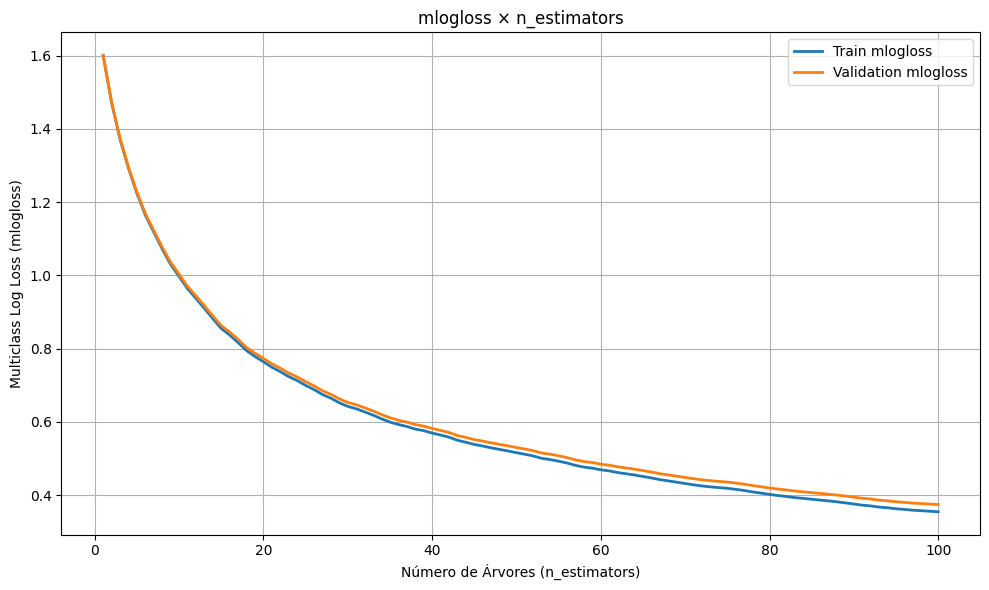

In [ ]:
# Plotar mlogloss vs n_estimators
train_mlogloss = evals_result['train']['mlogloss']
eval_mlogloss = evals_result['val']['mlogloss']
rounds = list(range(1, num_boost_round + 1))

plt.figure(figsize=(10, 6))
plt.plot(rounds, train_mlogloss, label='Train mlogloss', linewidth=2)
plt.plot(rounds, eval_mlogloss, label='Validation mlogloss', linewidth=2)
plt.xlabel('Número de Árvores (n_estimators)')
plt.ylabel('Multiclass Log Loss (mlogloss)')
plt.title('mlogloss × n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85     38153
         1.0       0.90      0.91      0.90     60925
         2.0       0.91      0.85      0.88     44102
         3.0       0.91      0.90      0.90     70565
         4.0       0.90      0.96      0.93    111877
         5.0       0.90      0.88      0.89     49378

    accuracy                           0.90    375000
   macro avg       0.90      0.89      0.89    375000
weighted avg       0.90      0.90      0.90    375000

✅ Accuracy: 0.902064


<Figure size 800x600 with 0 Axes>

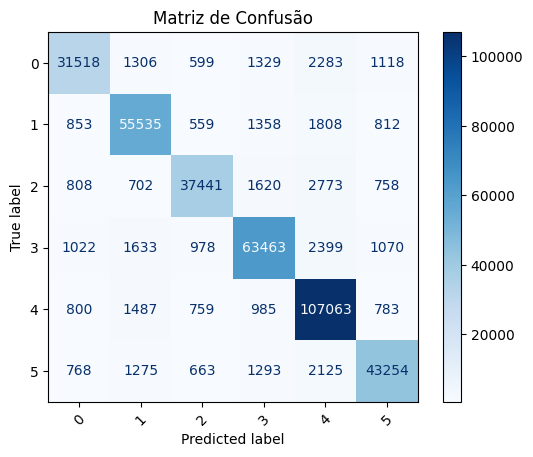

In [ ]:
# Previsões em forma de probabilidade
y_pred_prob = model.predict(dtest)

# Converter para rótulos (classe com maior probabilidade)
y_pred = np.argmax(y_pred_prob, axis=1)

# Valores reais
y_true = dtest.get_label()

print("📊 Classification Report:")
print(classification_report(y_true, y_pred))

print("✅ Accuracy:", accuracy_score(y_true, y_pred))

# Gerar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plotar a imagem
plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusão')
plt.show()